In [1]:
# imports
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries which we'll use just
# to produce some visualizations of our training
from lib.utils import montage
from lib import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
import PIL.ImageGrab
from matplotlib.pyplot import imshow,subplots,plot
import seaborn as sns
%matplotlib inline

def print_img_from_clipboard():
    img = PIL.ImageGrab.grabclipboard()
    fig, ax = subplots(figsize=(90, 30))
    imshow(img, interpolation='nearest')

In [3]:
#import mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST',one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# we are doing clusteting task , so we don't need Validation and Test. So we better concatenate train,
#test,validation parts to get more train data

X_train = np.concatenate([mnist.train.images,mnist.validation.images,mnist.test.images])

In [5]:
#lets define conv2d and maxpool wrappers
def conv2d(input_tensor,W,strides=1):
    return tf.nn.conv2d(input_tensor,W,strides=[1,strides,strides,1],padding='SAME')
def conv_2d_T(input_tensor,W,output_shape,strides=1):
    return tf.nn.conv2d_transpose(input_tensor,W,output_shape=[tf.shape(input_tensor)[0],output_shape[1],output_shape[2],output_shape[3]],strides=[1,strides,strides,1],padding='SAME')



In [6]:
#lets import iterate the batches to be used in train
def iterate_over_batches(input_array,batch_size=100):
    #input_values - np.array which is needed to be iterated
    #yeilds batched with size = batch_size
    total_values = len(list(input_array))
    #print(total_values)
    for index in range(int(total_values/batch_size)):
        start_index = index*batch_size
        end_index = start_index+batch_size
        yield input_array[start_index:end_index]
    if total_values%batch_size!=0.0:
        yield input_array[-int(total_values%batch_size):]

In [7]:
#lets create a fuction that creates deep convolutional network

def create_convolutional_encoder(input_placeholder,n_filters,filter_sizes,conv_shape=[28,28],channels=1,non_linear=tf.nn.relu):
    #input
    #conv_dimenstions - dimension list a conv layers 
    #
    #input_placeholder = tf.placeholder that contains input placeholder
    #conv_shape = shapes of  input images 
    #chanels = channges of the input images
    
    #output
    #
    #convolutional_output - output tensor with convolved images
    
    
    #at the start we will reshape the image
   
    
    reshaped_dimension = [-1]+conv_shape+[channels]
    current_input = tf.reshape(input_placeholder,shape=reshaped_dimension)    
    #then lets create an array which got all the dimensions
    W_list=[]
    shape_list = []
    n_input = channels
    #lets glue input placeholder to the convolutional layer
    
   
   
    for layer_index,filter_tuple in enumerate(list(zip(n_filters,filter_sizes))):
        n_output,filter_size = filter_tuple[0],filter_tuple[1]
        #creating layer with specific name
        with tf.variable_scope('encoder/layer%i' % layer_index):
            shape_list.append(current_input.get_shape().as_list())
            #create weight matrix of the layer. it reduces dimension from n_input to n_output by using linear algebra
            conv_dimension = [filter_size,filter_size,n_input,n_output]
            with tf.name_scope('W'):
                W = tf.Variable(tf.random_normal(name='W',shape=conv_dimension,mean=0.0,stddev=0.02))
                W_list.append(W)
            #lets convolve and add bias
            with tf.name_scope('conv_2d'):
                conv = conv2d(current_input,W,strides=2)
            with tf.name_scope('non_linear'):
                non_linear_transformation = non_linear(conv)
            current_input,n_input = non_linear_transformation,n_output
    encoder_output = non_linear_transformation
    #lets reverse our lists to be used by decoder
    W_list = W_list[::-1]
    shape_list = shape_list[::-1]
    reversed_filters = n_filters[::-1]
    reversed_filters = reversed_filters[1:] + [channels]
    return encoder_output,W_list,shape_list,reversed_filters

In [8]:
#lets create a fuction that creates autoencoder
#first part of it is encoder. you we just need to create a subgraph that somehow reduces dimensions
def create_decoder(encoder_output,W_list,shape_list,reversed_filters,non_linear=tf.nn.relu):
    #input
    #W_list - list of Ws of the encoder
    #encoder_output = tf.tensor that contains encoder output
    #shape list - list of convolved shapes
    #reversed_filters - reversed list of n filters
    #non_linear = tf.nn.* non_linear function
    
    #output
    #decoder output - tensor with decoded values
    
    current_input = encoder_output
    n_input = int(encoder_output.get_shape()[1])
    n_shapes = int(len(shape_list))
    #lets glue encoder output to decoder  by  creating each decoder layer
   
    for layer_index,n_output in enumerate(shape_list):
        #creating layer with specific name
        with tf.variable_scope('decoder/layer%i_T' % (n_shapes-layer_index-1)):
            #create weight matrix of the layer. it reduces dimension from n_input to n_output by using linear algebra
            with tf.name_scope('W_T'):
                #W_to_upload = tf.contrib.copy_graph.copy_variable_to_graph(W_list[layer_index][0],to_graph=tf.Graph().as_default())
                W = W_list[layer_index]
            with tf.name_scope('conv_2d'):
                conv = conv_2d_T(current_input,W,n_output,strides=2)
            with tf.name_scope('non_linear'):
                non_linear_transformation = non_linear(conv)
            #and use this transformation and its column space as an input to the next layer
            current_input,n_input = non_linear_transformation,n_output
    decoder_output = non_linear_transformation
    return decoder_output

In [9]:
#lets create a fuction that runs the fucking training


def train_autoencoder(X_train,X,loss,decoder_output=None,optimizer=tf.train.AdamOptimizer,\
                                          learning_rate=1e-3,n_epochs = 10 ,\
                                         standartize=True,save=False,\
                                          log=False,gif=False,show_img=False
                                         ):
        #X_Train, - array train
        #X input placeholder of the graph
        #loss - loss which will be optimized
        
        #metric - target metric to calculate
        #tensor that - buddy that encodes than decodes
        #learning rate 
        #n_epochs
        #standartize - whether to substract mean
        #save - filename - if specified saves model to filename
        #log - filename - if specified will log the train to filename
        #gif - filename - if specified will create a fucking gif
        
        #we will substract mean if required
        if standartize:
            mean_value = np.mean(X_train,axis=0)
        else:
            mean_value = np.zeros(X_train.shape[1])
        
        #lets initialize values of the variables
        with tf.name_scope('Optimizer'):
            optimizer = optimizer(learning_rate=learning_rate).minimize(loss)
        
        init_op = tf.global_variables_initializer()
        #we will log loss and metric if requiored
       
        loss_sum = tf.scalar_summary('train_loss',loss)
        #metric_sum = tf.scalar_summary('train_accuracy',metric)
        summapy_op = tf.merge_summary([loss_sum])
        
        #we will save model if required
        if save:
            saver = tf.train.Saver()
        #store imgs in a list to create a gif
        if show_img or gif:
            test_examples = X_train[:25]
            test_images =montage(test_examples.reshape((-1, 28, 28)))
        
        if show_img or gif:
            imgs=[]
        #lets start the session
        with tf.Session() as sess:
            sess.run(init_op)
            #lets create a log writer if required and counter
            if log:
                writer = tf.train.SummaryWriter(log, graph=tf.get_default_graph())
                
                
            #lets start training
            for epoch in range(n_epochs):
                #over all the batches lets train
                for batch_xs in iterate_over_batches(X_train):
                    #lets just train if its too boring
                    
                    sess.run(optimizer, feed_dict={X: (batch_xs-mean_value)})
                if log:
                    
                    epoch_loss,train_sum = sess.run([loss,summapy_op], feed_dict={X:(X_train[:10000]-mean_value)})
                    writer.add_summary(train_sum,epoch)
                else:
                    epoch_loss = sess.run(loss, feed_dict={X:(X_train[:10000]-mean_value)})
                    
                print('epoch %i loss: %f' % (epoch,epoch_loss))
                if show_img or gif:
                    if decoder_output== None:
                        print('Provide decoder tensor to reconstruct the image')
                        return None
                    recon = sess.run(decoder_output, feed_dict={X: X_train[:25] - mean_value})
                    recon =np.clip((recon + mean_value).reshape((-1, 28, 28)), 0, 255)
                    img_i = montage(recon)
                    imgs.append(img_i)
                if show_img:
                    if epoch % show_img ==0:
                        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
                        axs[0].imshow(test_images)
                        axs[0].set_title('Original')
                        axs[1].imshow(img_i)
                        axs[1].set_title('Synthesis')
                        fig.canvas.draw()
                        plt.show()
            if save:
                saver.save(sess,save)
            if gif:
                x = [test_images]*(int(len(imgs)/2))+imgs
                gif.build_gif(x, saveto=gif) 
            if log:
                writer.close()

In [10]:
#parameters
tf.reset_default_graph()


#lets specify hyperparamenets
n_filters = [8,4,2]
filter_sizes = [4,4,4]
non_linear=tf.nn.tanh

#lets finally build the fucking model
#lets create a encoder
with tf.name_scope('X_train'):
    X = tf.placeholder(tf.float32,shape=[None,784])
#lets build en encoder and then decoder
encoder_output,W_list,shape_list,reversed_filters = create_convolutional_encoder(X,n_filters,filter_sizes)
decoder_output = create_decoder(encoder_output,W_list,shape_list,reversed_filters)
decoder_output = tf.reshape(decoder_output,shape=[-1,784])

with tf.name_scope('MSE'):
    cost = tf.reduce_mean(tf.squared_difference(X,decoder_output),1)
    mean_squared_difference = tf.reduce_mean(cost)    


epoch 0 loss: 0.036385


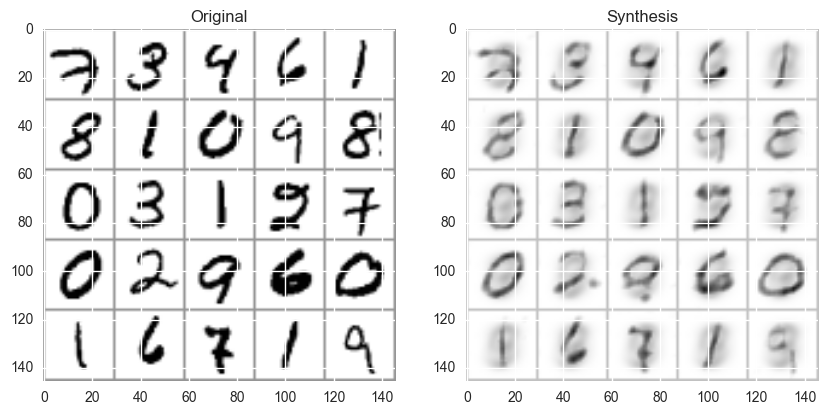

epoch 1 loss: 0.033758
epoch 2 loss: 0.032690
epoch 3 loss: 0.032000
epoch 4 loss: 0.031619
epoch 5 loss: 0.031392
epoch 6 loss: 0.031142
epoch 7 loss: 0.030959
epoch 8 loss: 0.030830
epoch 9 loss: 0.030728


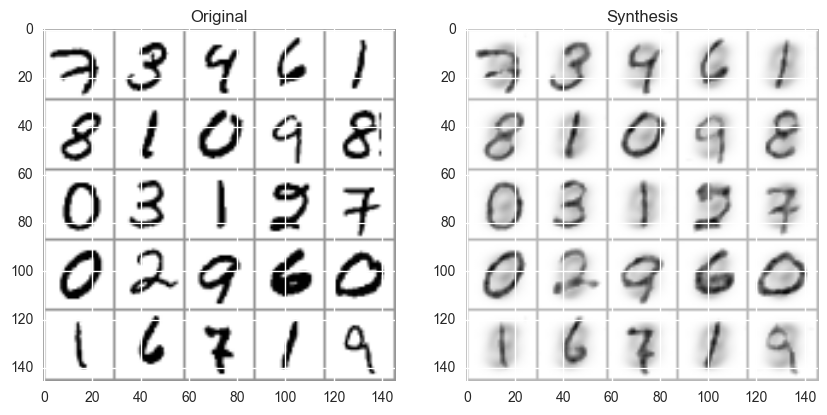

In [103]:
#there is the train fot [16,8,4] convolutions.
train_autoencoder(X_train,X,mean_squared_difference,decoder_output=decoder_output,optimizer=tf.train.AdamOptimizer,\
                                          learning_rate=1e-3,n_epochs = 10 ,\
                                         standartize=True,save=False,\
                                          log='log',gif=False,show_img=9)


In [ ]:
#result looks much sharper than fully connected example

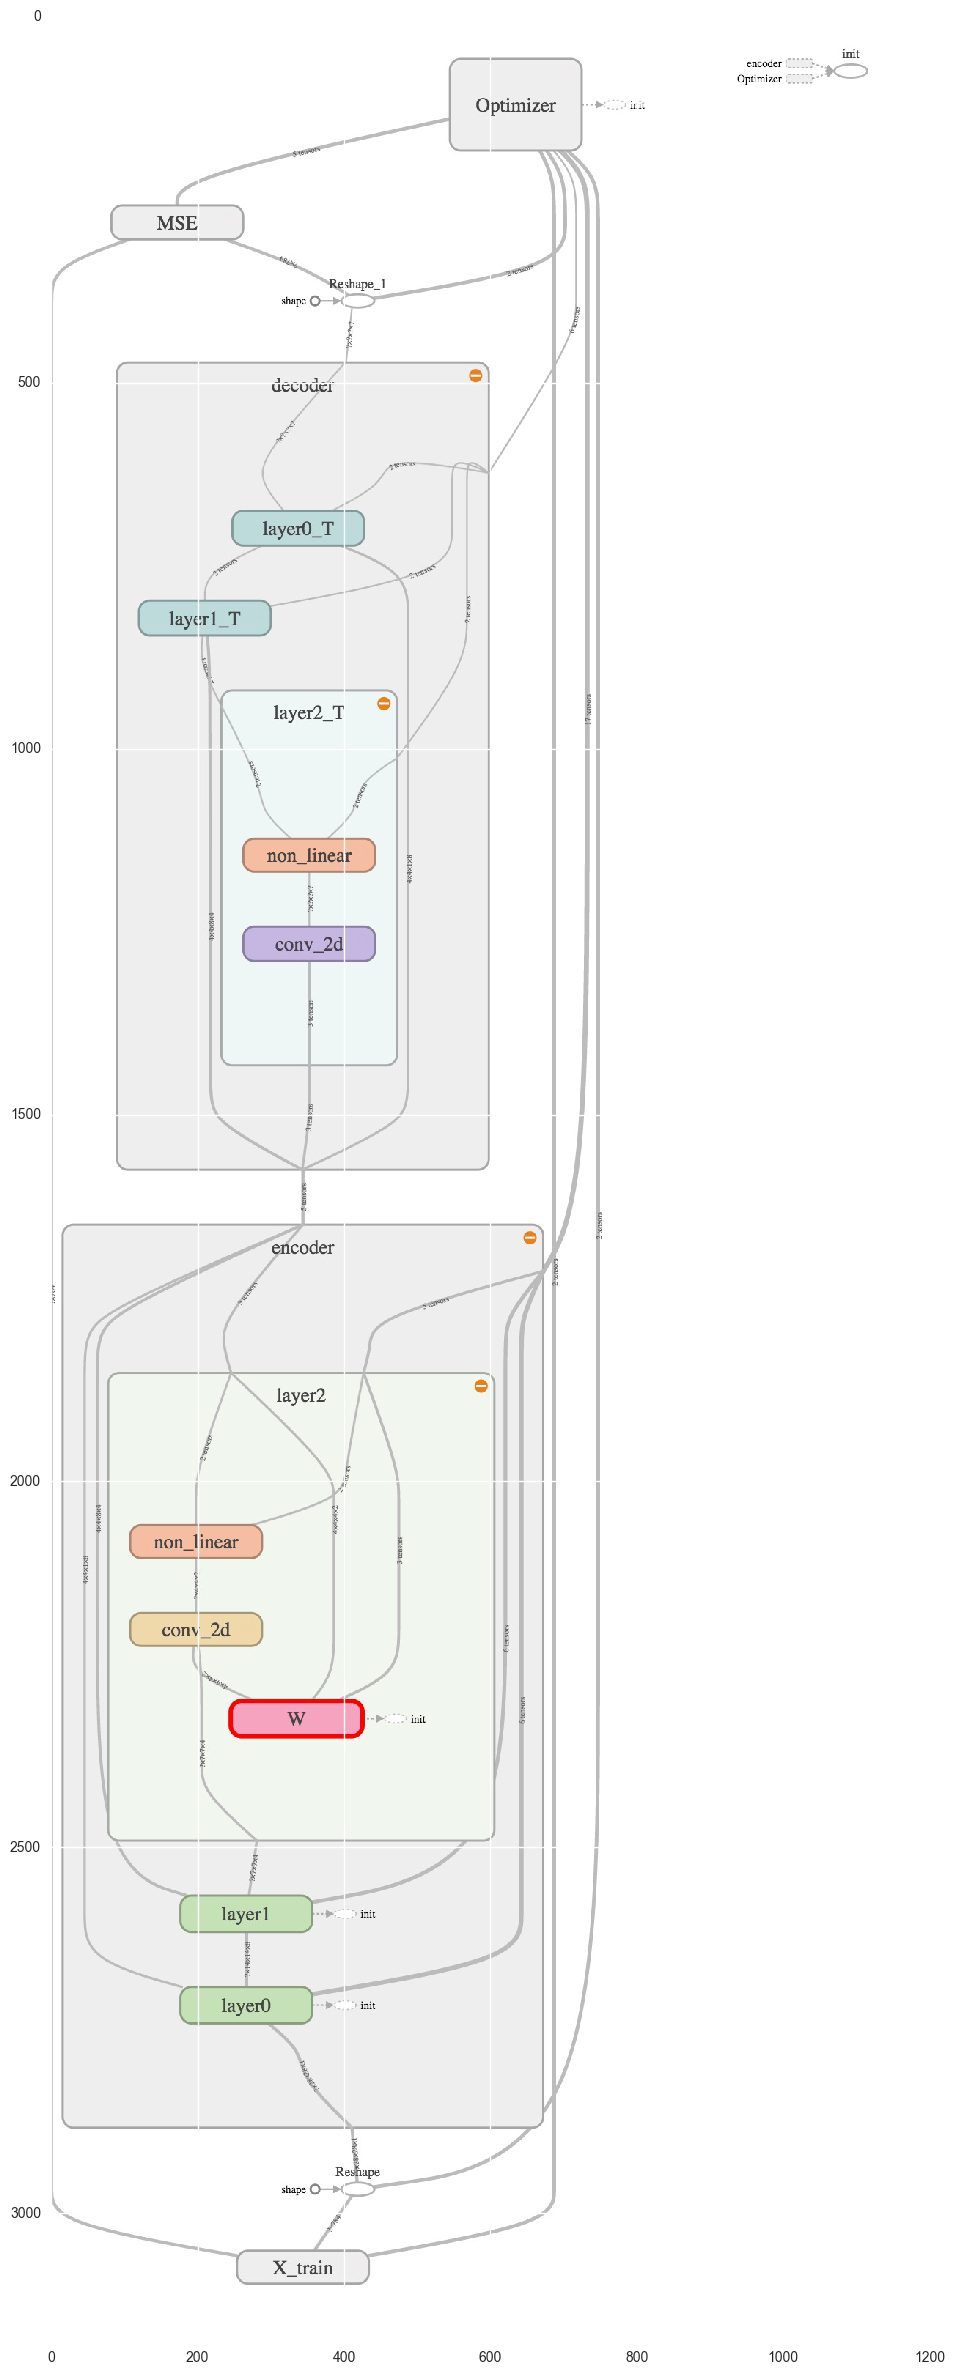

In [13]:
#lets check the graph
print_img_from_clipboard()

In [105]:
#lets train for 8,4,2 convolutions

epoch 0 loss: 0.046723


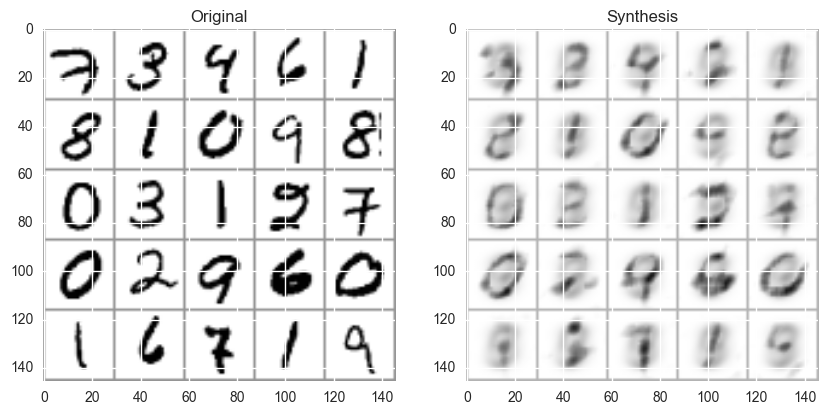

epoch 1 loss: 0.045019
epoch 2 loss: 0.044003
epoch 3 loss: 0.043408
epoch 4 loss: 0.043123
epoch 5 loss: 0.042949
epoch 6 loss: 0.042839
epoch 7 loss: 0.042699
epoch 8 loss: 0.042572
epoch 9 loss: 0.042424


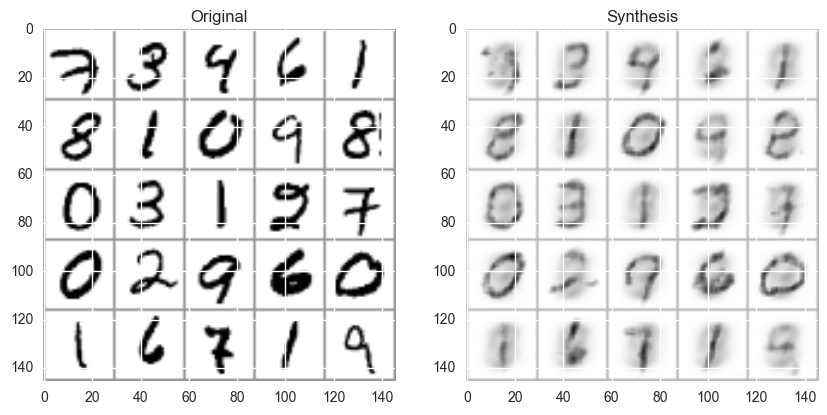

In [106]:
#ill train one time here just to save the graph
train_autoencoder(X_train,X,mean_squared_difference,decoder_output=decoder_output,optimizer=tf.train.AdamOptimizer,\
                                          learning_rate=1e-3,n_epochs = 10 ,\
                                         standartize=True,save=False,\
                                          log='log',gif=False,show_img=9
                                         )
#and it shows reconstructions after one epoch of 32 label encoder

In [108]:
#sharp too, but I suppose it will need more training steps